以下のサイトを利用した

https://dreamer-uma.com/mcmc-ising/

In [1]:
import numpy as np
import random
import scipy as sp
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
class LatticeIsing_2D():
    def __init__(self, N, J, h):
        """
        Attributes:
            N: 格子サイズ
            J: 相互作用
            h: 磁場
        """
        self.N=N
        self.J=J
        self.h=h
    
    def neighor_spin_sum(self, state, x, y):

        center_spin = state[y, x]
        right, left, up, down=x+1, x-1, y+1, y-1

        # 周期境界条件
        if right>=self.N:
            right_spin=state[y, 0]
        else:
            right_spin=state[y, right]
            
        if left<0:
            left=self.N-1
            left_spin=state[y, left]
        else:
            left_spin=state[y, left]
            
        if down<0:
            down=self.N-1
            down_spin=state[down, x]
        else:
            down_spin=state[down, x]
    
        if up>=self.N:
            up_spin=state[0, x]
        else:
            up_spin=state[up, x]
            
        neighor_spin_sum=self.J*center_spin*(right_spin+left_spin+up_spin+down_spin)
        return neighor_spin_sum

    # エネルギーを計算
    def energy(self, state):
        energy=0
        for x in range(self.N):
            for y in range(self.N):
                energy -= self.neighor_spin_sum(state, x, y)/2
        energy -= self.h*np.sum(state)
        return energy
    
    # 磁化を計算
    def magnetization(self, state):
        return np.mean(state)

マルコフ連鎖モンテカルロ法

・gibbsサンプリングのコードが間違っているかも

In [3]:
state_dynamics=np.zeros((3, 4, 4))
print(state_dynamics)

state_dynamics[0]

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
# flip_order_x = list(range(dist.N))
#         flip_order_y = list(range(dist.N))
#         random.shuffle(flip_order_x)
#         random.shuffle(flip_order_y)
        
flip_order_x = list(range(10))
print(flip_order_x)

random.shuffle(flip_order_x)
print(flip_order_x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 5, 1, 7, 4, 0, 6, 2, 9, 8]


In [5]:
l = [0, 1, 2, 3, 4]

random.shuffle(l)
print(l)
# [0, 3, 2, 4, 1]

[4, 2, 3, 1, 0]


In [6]:
class IsingMC():
    def __init__(self, method):
        self.method=method

    def run_mcmc(self, dist, init_state, n_step=1000, beta=1.0):
        
        state=init_state
        state_dynamics=np.zeros((n_step+1, dist.N, dist.N))
        state_dynamics[0]=state
        AR_dynamics=[]

        for step in tqdm(range(n_step)):
            if self.method=="gibbs":
                state, AR = self.step_Gibbs(dist, state, beta=beta)
            else:
                state, AR = self.step_MH(dist, state, beta=beta)
            
            AR_dynamics.append(AR)
            state_dynamics[step+1] = state
        print(f'ACCEPTANCE RATE : {np.mean(AR_dynamics):.3f}')
        return state_dynamics, AR_dynamics    
    
    def step_MH(self, dist, state, beta=1.0):
        # select rule
        flip_order_x = list(range(dist.N))
        flip_order_y = list(range(dist.N))
        random.shuffle(flip_order_x)
        random.shuffle(flip_order_y)
        
        n_flg = 0
        for x in flip_order_x:
            for y in flip_order_y:
                delta_energy = 2 * (dist.neighor_spin_sum(state, x, y) + dist.h * state[y, x])
                trans_prob = np.exp(-beta * delta_energy)
                if delta_energy < 0:
                    state[y, x] *= -1
                    n_flg += 1
                elif np.random.random() <= trans_prob:
                    state[y, x] *= -1
                    n_flg += 1
        return state, n_flg / (dist.N * dist.N)

    
    def step_Gibbs(self, dist, state, beta=1.0):
        # select rule
        flip_order_x = list(range(dist.N))
        flip_order_y = list(range(dist.N))
        random.shuffle(flip_order_x)
        random.shuffle(flip_order_y)
        for x in flip_order_x:
            for y in flip_order_y:
                neighors = (dist.neighor_spin_sum(state, x, y)+dist.h*state[y, x])/state[y, x]
                trans_prob = np.exp(beta*neighors)/(np.exp(beta*neighors)+np.exp(-beta*neighors))
                if np.random.random()<=trans_prob:
                    state[y, x] *=1
                else:
                    state[y, x] *=-1
        return state, 1.0

In [8]:
# Ising Instance
N, h=8, 0.0
J = 1
dist=LatticeIsing_2D(N, J, h)
# MCMC Instance
n_step=3000
init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
sampler=IsingMC(method="metropolis")
state_dynamics, AR_dynamics = sampler.run_mcmc(dist, init_state, beta=0.5, n_step=n_step)

100%|██████████| 3000/3000 [00:00<00:00, 3487.18it/s]

ACCEPTANCE RATE : 0.079


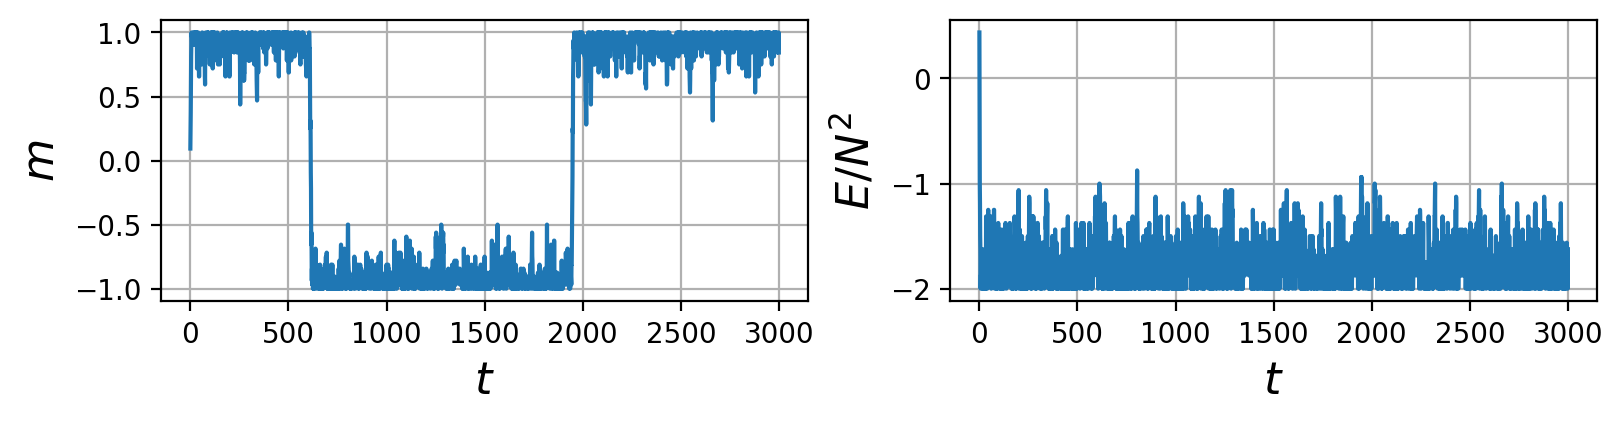

In [9]:
m_dynamics = np.array([dist.magnetization(state) for state in state_dynamics])
energy_dynamics = np.array([dist.energy(state)/(dist.N*dist.N) for state in state_dynamics])

fig, axes=plt.subplots(1, 2, figsize=(8, 2), constrained_layout=True, dpi=200)
axes[0].plot(m_dynamics)
axes[0].set_xlabel(r"$t$", fontsize=16)
axes[0].set_ylabel(r"$m$", fontsize=16)
axes[0].grid()
axes[1].plot(energy_dynamics)
axes[1].set_ylabel(r"$E/N^2$", fontsize=16)
axes[1].set_xlabel(r"$t$", fontsize=16)
axes[1].grid()
plt.show()

In [13]:
# Ising Instance
N, h=8, 0.0
Jx=np.ones((N, N))
Jy=np.ones((N, N))
dist=LatticeIsing_2D(N, J, h)
n_step=100
# MCMC Instance
init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
sampler=IsingMC(method="metropolis")
state_dynamics, AR_dynamics = sampler.run_mcmc(dist, init_state, beta=80.0, n_step=n_step)

fig, ax = plt.subplots()
ims = []
ani_step=100
for step in range(ani_step):
    ax.axis("off")
    im = ax.imshow(state_dynamics[step], animated=True, cmap="gray")
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims)
rc('animation', html='jshtml')
plt.close()
anim

100%|██████████| 100/100 [00:00<00:00, 3118.26it/s]

ACCEPTANCE RATE : 0.013
